## 모듈 로딩

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.layers import LSTM, Dense, Conv1D, Dropout
from keras import Sequential
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
input_1 = pd.read_csv(r'./data/input_1.csv')
input_2 = pd.read_csv(r'./data/input_2.csv')
input_3 = pd.read_csv(r'./data/input_3.csv')
target = pd.read_csv(r'./data/target.csv')
input_data = pd.concat([input_1, input_2.iloc[:, 2:]], axis=1)
input_data['DATE'] = pd.to_datetime(input_data['DATE'])
target['DATE'] = pd.to_datetime(target['DATE'])

target.set_index('DATE', inplace=True)
input_data.set_index('DATE', inplace=True)

In [3]:
input_data.head()

,TCL_AT,TCL_LT,TCL_HT,TEMP_EF_CAP,TEMP_EF_DONGNAM,TEMP_EF_DAEGYUNG,TEMP_EF_CHOONG,TEMP_EF_HONAM,TEMP_EF_MEAN,POWER_WATER,...,ELEC_PUBLIC,ELEC_SERVICE,ELEC_CIVIL_SUM,ELEC_ARGRI_FISHING,ELEC_MINING,ELEC_MANUFACT,ELEC_INDSUM,RV,GAS,OTHER OIL PRODUCT
DATE,,,,,,,,,,,,,,,,,,,,,
1996-01-01,0.004764,-0.189311,0.240528,0.84711,5.91778,6.73765,3.33479,1.88651,3.744768,363291,...,557379,3616542,6988059,301811,80421,8854576,9236808,0.97,26.94,27.86
1996-02-01,0.007708,-0.226982,0.372691,0.81430,5.90875,6.73291,3.32638,1.87883,3.732234,356379,...,558610,3551611,6898533,327617,70471,8067220,8465308,0.93,26.94,29.04
1996-03-01,0.137972,-0.045631,0.367739,0.60731,5.81529,6.67634,3.22000,1.78740,3.621268,362980,...,528672,3333225,6416945,345359,81877,9250086,9677322,0.96,26.94,27.99
1996-04-01,0.261910,0.029456,0.582132,0.24132,5.71003,6.61264,3.07795,1.66054,3.460496,367415,...,555354,3430624,6615182,292235,84596,9274014,9650845,0.94,26.94,28.74
1996-05-01,0.428759,0.242892,0.688458,-0.38328,5.67433,6.58956,3.02586,1.62083,3.305460,440662,...,511468,3333483,6370027,302913,80963,9274169,9658045,0.92,26.94,29.18


## 정규화

In [4]:
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_input_data = scaler.fit_transform(input_data)
# scaled_target = scaler.fit_transform(target)

In [5]:
# scaled_input_data = pd.DataFrame(scaled_input_data)
# scaled_input_data.columns = input_data.columns
# scaled_target = pd.DataFrame(scaled_target)
# scaled_target.columns = target.columns

## EDA(ELEC_MANUFACT)

In [6]:
ELEC_MANUFACT = input_data['ELEC_MANUFACT']

In [7]:
ELEC_MANUFACT

DATE
1996-01-01     8854576
1996-02-01     8067220
1996-03-01     9250086
1996-04-01     9274014
1996-05-01     9274169
                ...   
2020-08-01    20803586
2020-09-01    21325400
2020-10-01    20053280
2020-11-01    20689055
2020-12-01    22046334
Name: ELEC_MANUFACT, Length: 300, dtype: int64

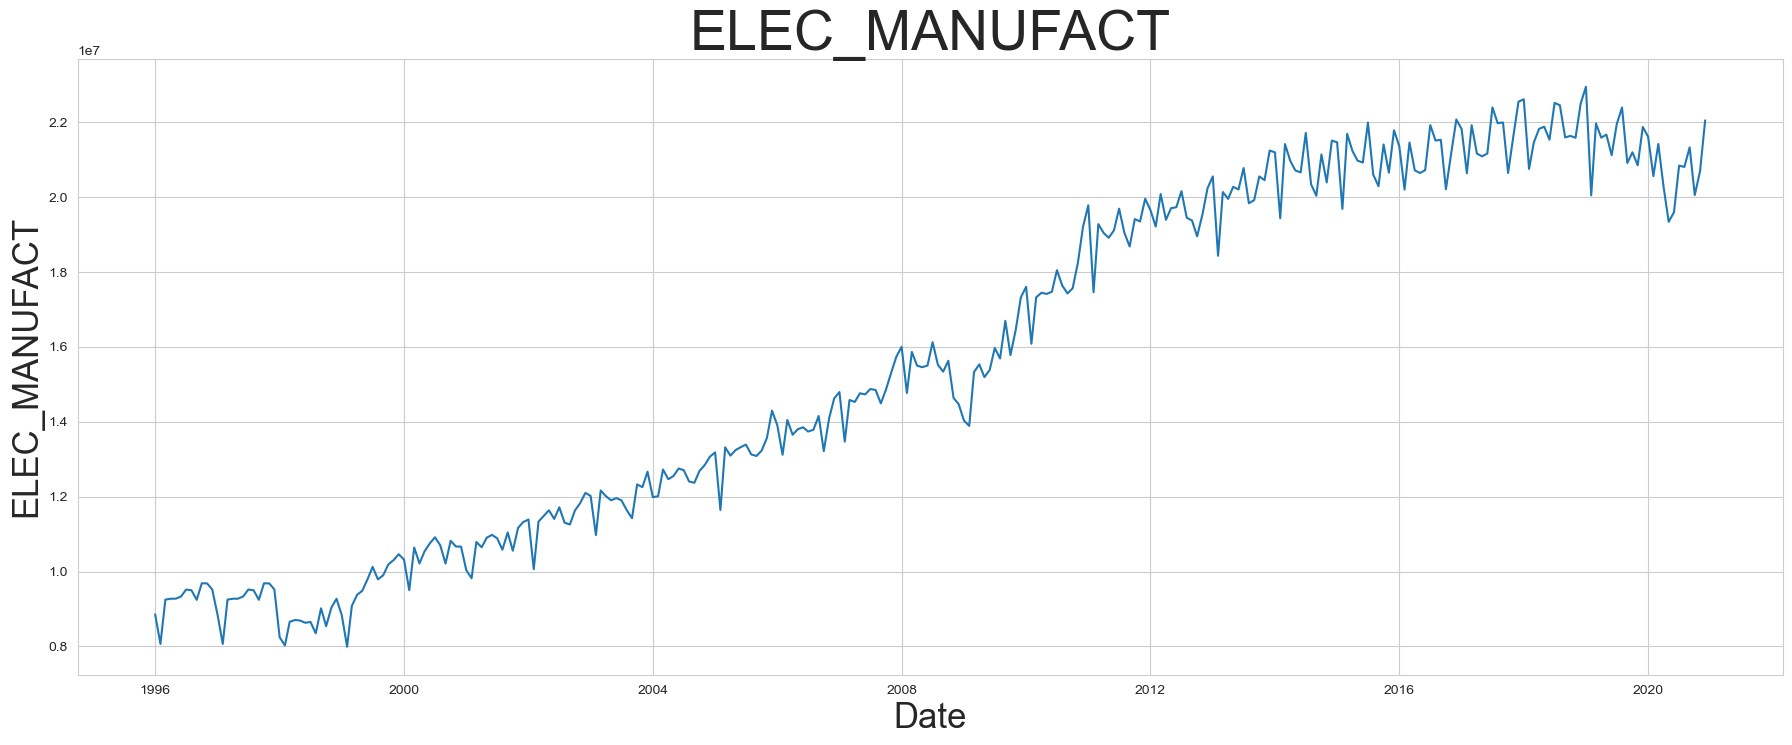

In [8]:
## 시각화
plt.figure(figsize=(22, 8))
plt.plot(ELEC_MANUFACT.index, ELEC_MANUFACT)
plt.title("ELEC_MANUFACT", size=40)
plt.xlabel("Date", size=25)
plt.ylabel("ELEC_MANUFACT", size=25)
plt.show()

<Figure size 640x480 with 0 Axes>

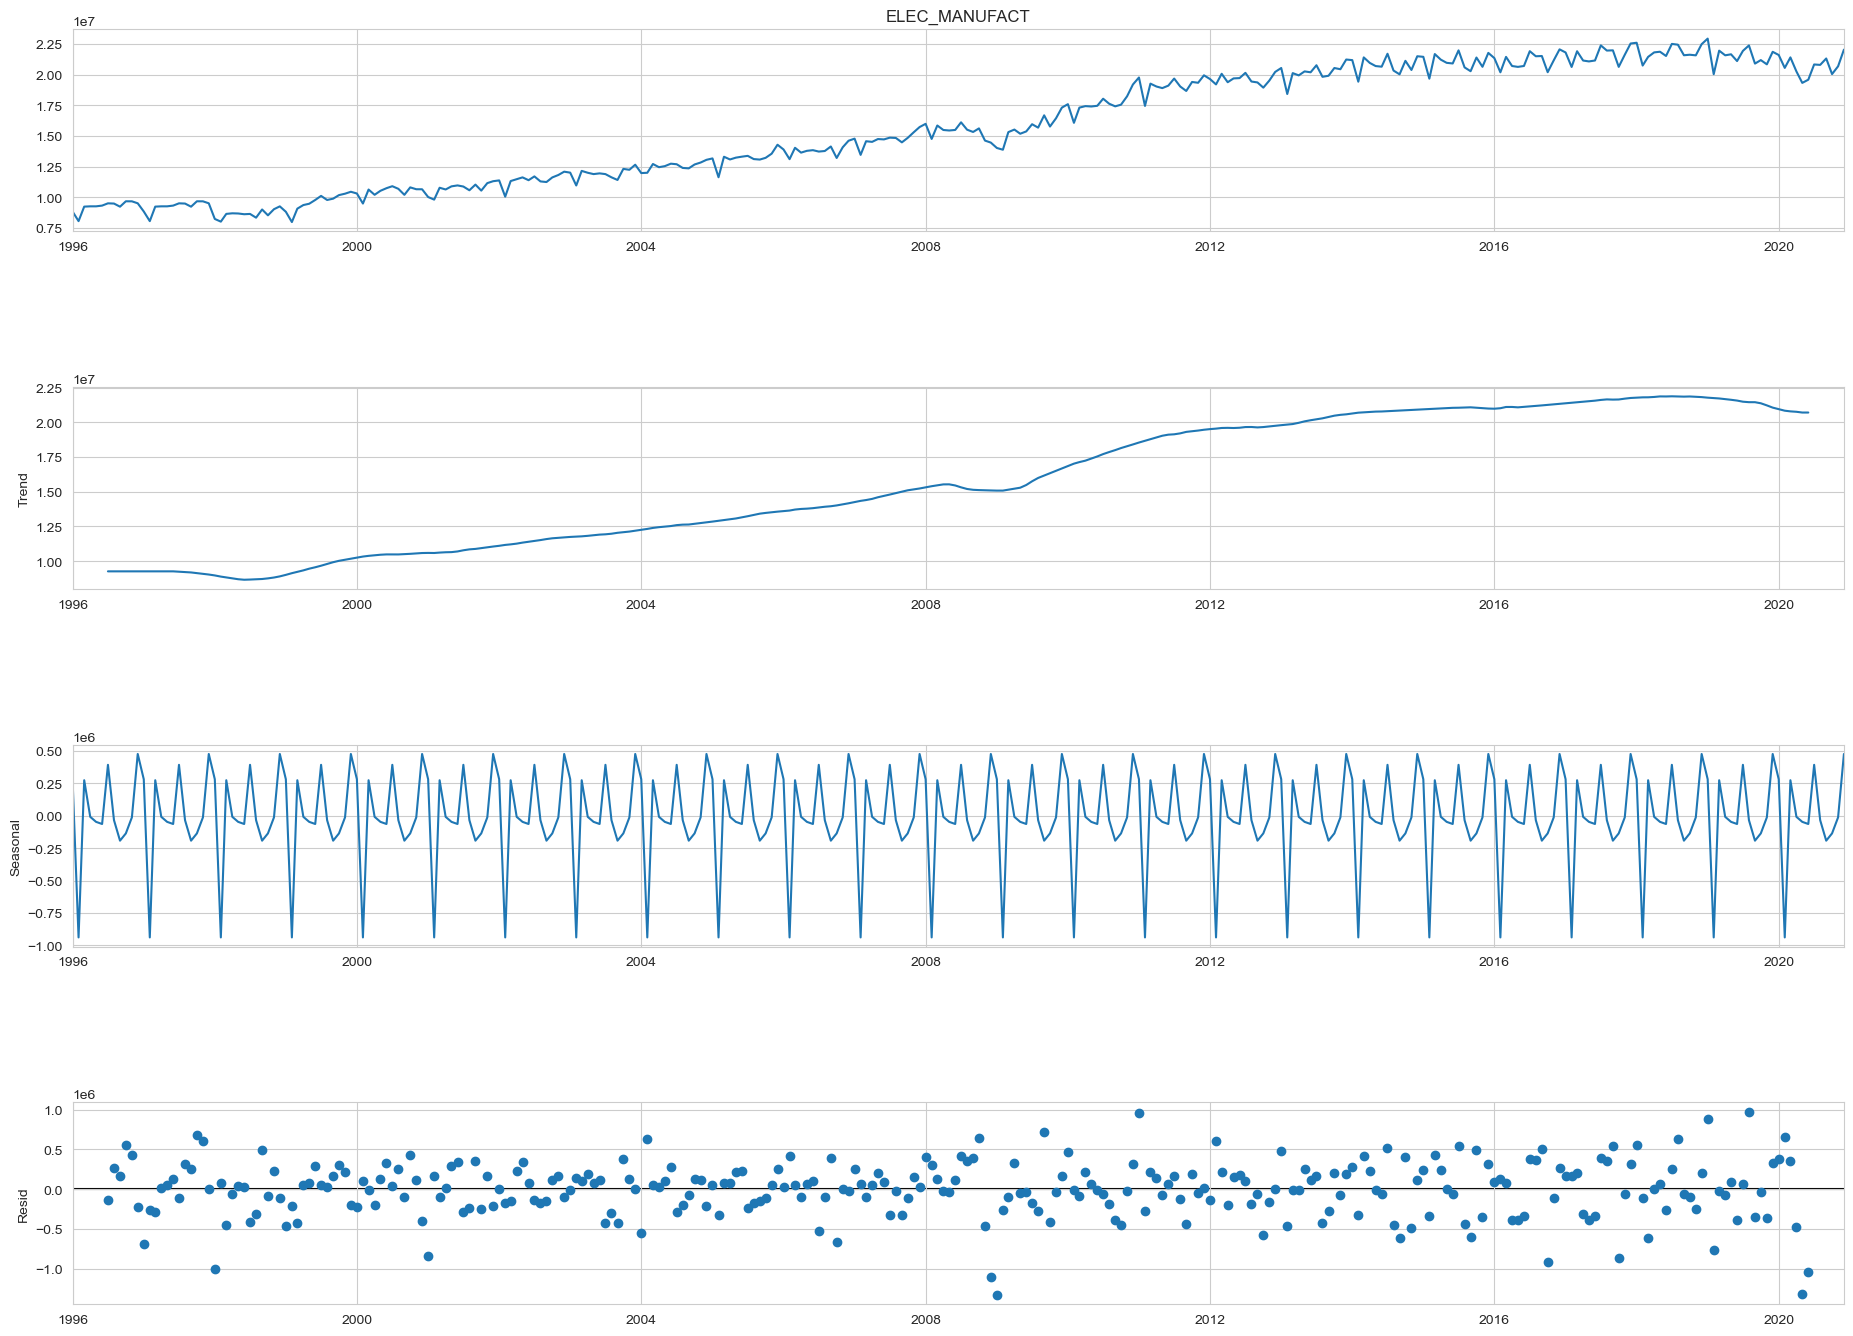

In [9]:
result = seasonal_decompose(ELEC_MANUFACT, model='additive')

fig = plt.figure()
fig = result.plot()
fig.set_size_inches(20, 15)

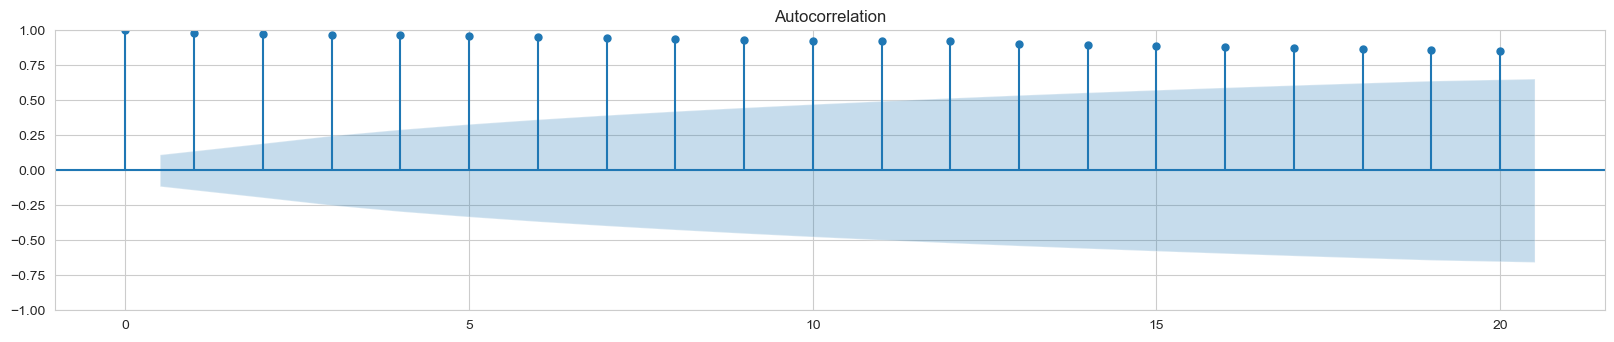

In [10]:
### 정상성 판별을 위한 ACF그래프
import statsmodels.api as sm

fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ELEC_MANUFACT, lags=20, ax=ax1)

### 값이 아주 천천히 작아지기 때문에 정상성을 만족하지 않는것 같음

In [11]:
# 단위근 검정 ADF
from statsmodels.tsa.stattools import adfuller

result = adfuller(ELEC_MANUFACT)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.029459
p-value: 0.742369
Critical Values:
	1%: -3.453
	5%: -2.872
	10%: -2.572


### p-Value가 0.05를 넘기때문에 H0(자료가 정상성을 만족하지 않는다) 기각 불가능

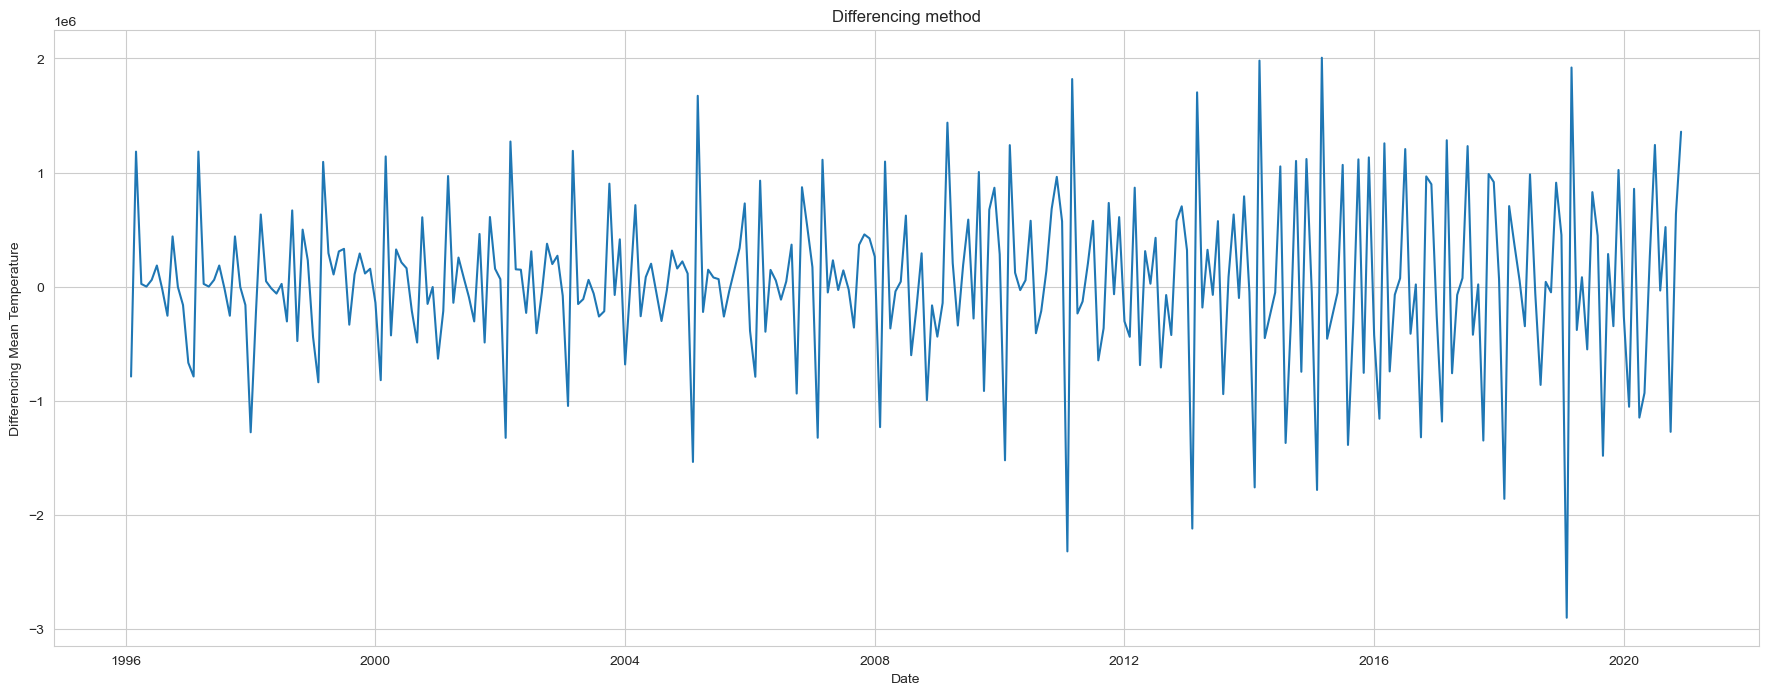

In [12]:
### 1차 차분
ELEC_MANUFACT_diff = ELEC_MANUFACT - ELEC_MANUFACT.shift()
plt.figure(figsize=(22, 8))
plt.plot(ELEC_MANUFACT_diff)
plt.title("Differencing method")
plt.xlabel("Date")
plt.ylabel("Differencing Mean Temperature")
plt.show()

### 일정한 패턴이 보이지 않고 정상성을 만족하는 듯 함

In [13]:
# 단위근 검정 ADF
from statsmodels.tsa.stattools import adfuller

ELEC_MANUFACT_diff.fillna(method='backfill', inplace=True)
result = adfuller(ELEC_MANUFACT_diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.533984
p-value: 0.000171
Critical Values:
	1%: -3.453
	5%: -2.872
	10%: -2.572


### p-Value가 0.05를 이하임 H0(자료가 정상성을 만족하지 않는다) 기각

C:\ProgramData\Anaconda3\envs\EV_PY37\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


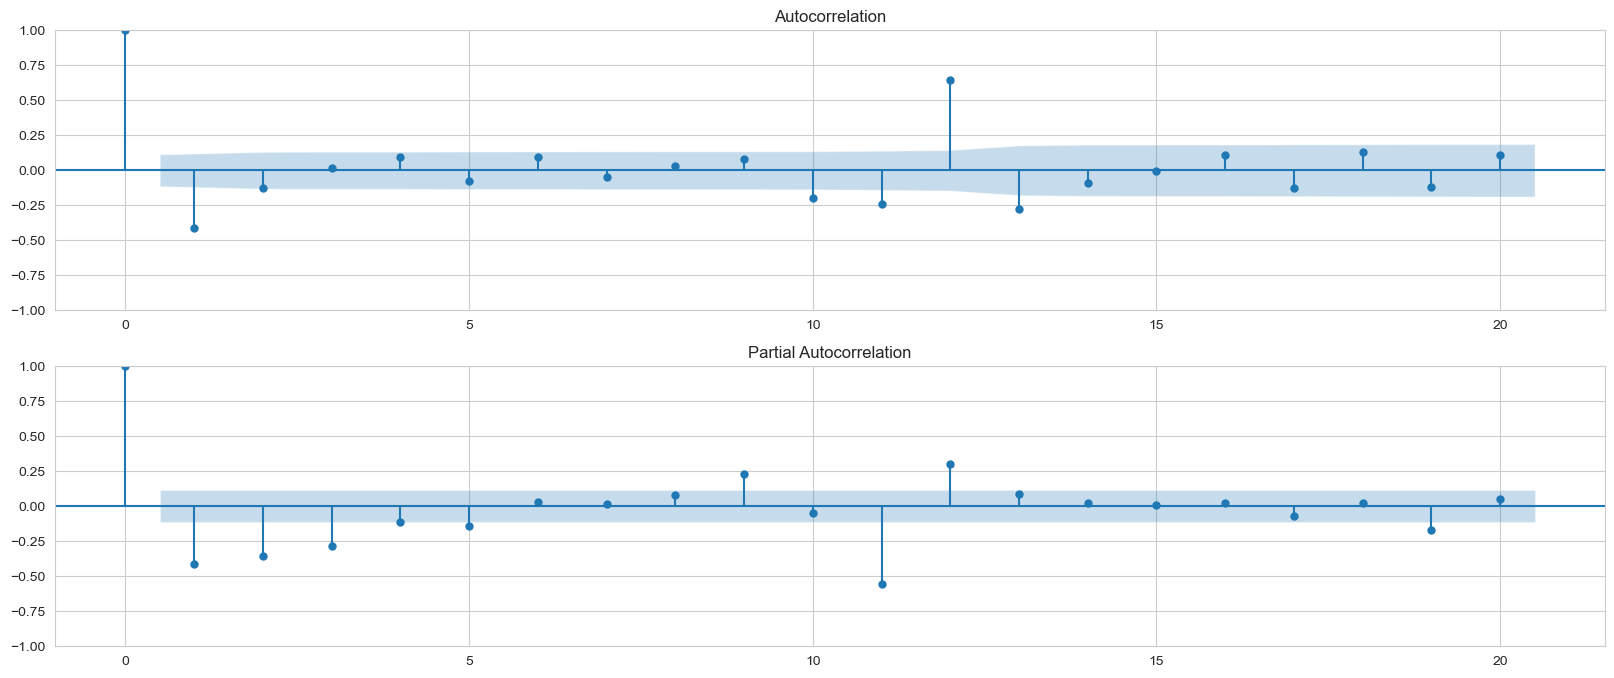

In [14]:
### 차분된 데이터로 ACF, PACG그래프 그려보기
import statsmodels.api as sm

fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ELEC_MANUFACT_diff[1:], lags=20, ax=ax1)  #
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ELEC_MANUFACT_diff[1:], lags=20, ax=ax2)  # , lags=40

## ARIMA 모델 학습

In [ ]:
# import itertools
#
# d = range(1, 2)
# p = q = range(0, 3)
# pdq = list(itertools.product(p, d, q))
# #P,D,Q,S의 경우에는 위에서 각각 1,1,1,12로 결정
#
# for param in pdq:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(ELEC_MANUFACT,order=param,seasonal_order=(1,1,1,12))
#             results = mod.fit()
#             print('ARIMA{}x{}12 - AIC:{} - BIC {}'.format(param,(1,1,1,12),results.aic,results.bic))
#         except:
#             continue;

C:\ProgramData\Anaconda3\envs\EV_PY37\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  
C:\ProgramData\Anaconda3\envs\EV_PY37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\EV_PY37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\EV_PY37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\EV_PY37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No fr

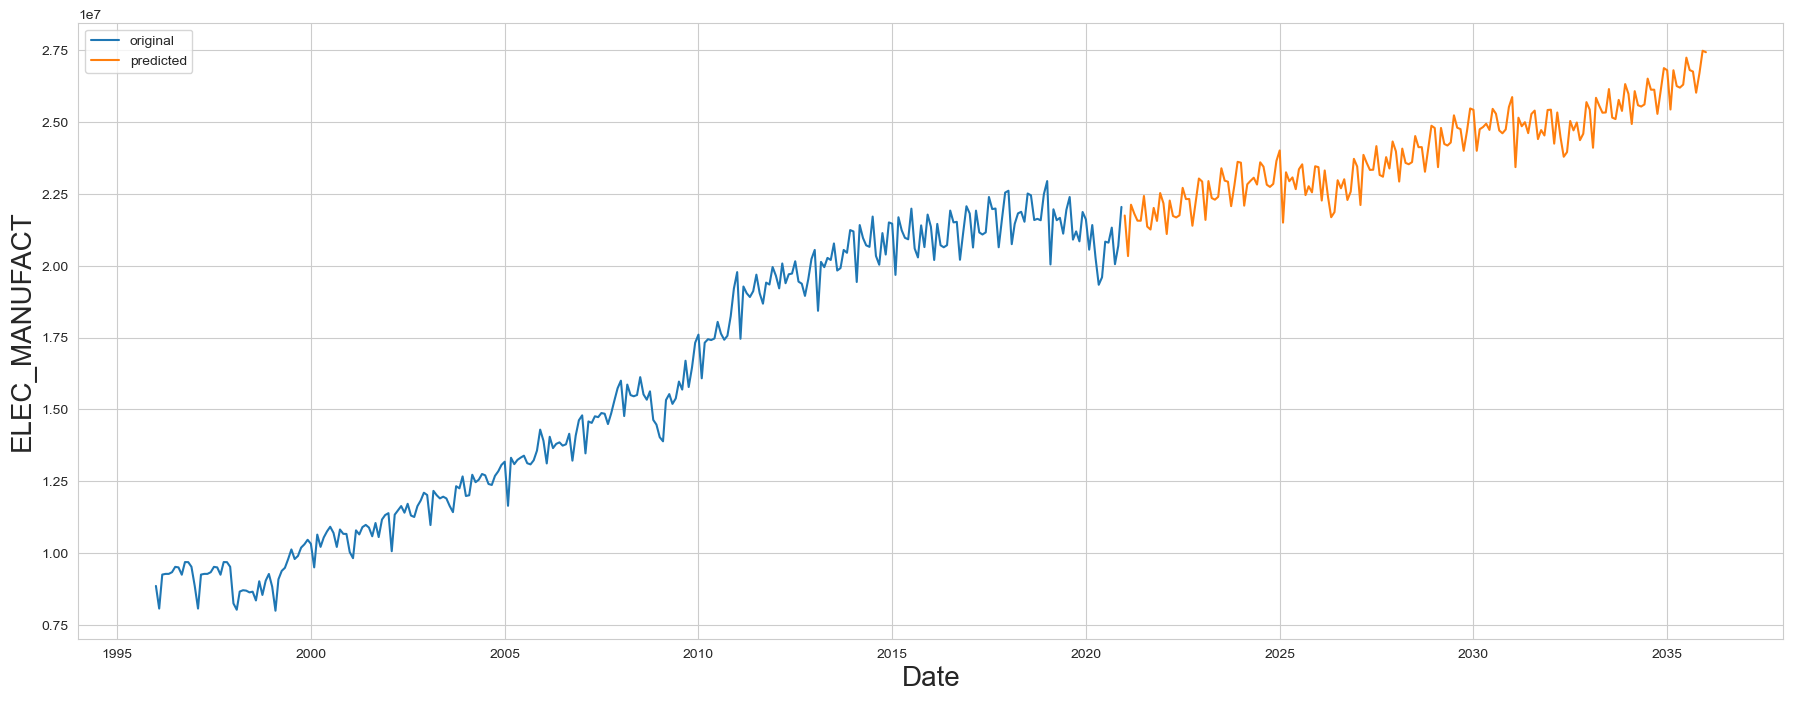

In [19]:
import statsmodels.api as sm

# fit model
model = sm.tsa.arima.ARIMA(ELEC_MANUFACT, order=(2, 1, 1))
model_fit = model.fit()

model2 = sm.tsa.statespace.SARIMAX(ELEC_MANUFACT,order=(0,1,1), seasonal_order=(1,1,1,72))
model2_fit = model2.fit()

# predict
forecast = model_fit.predict(start=200, end=300, dynamic=True)
forecast2 = model2_fit.predict(start=300, end=480, dynamic=True)

# visualization
plt.figure(figsize=(22, 8))
plt.plot(ELEC_MANUFACT.index, ELEC_MANUFACT, label="original")
plt.plot(forecast2, label="predicted")
plt.xlabel("Date", size=20)
plt.ylabel("ELEC_MANUFACT", size=20)
plt.legend()
plt.show()